In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylops
from scipy.signal import butter, filtfilt
import wavelets
import warnings
import scienceplots

warnings.filterwarnings("ignore")

plt.style.use(["bmh", "science", "notebook", "grid"])
# Shades of blue
PRIMARY = "#0072b2"
PRIMARY_DARK = "#000080"
# Shades of red
SECONDARY = "#a60628"
SECONDARY_DARK = "#79011B"
# Shades of green
TERCIARY = "#228b22"
TERCIARY_DARK = "#556b2f"
# Shades of yellow
ALTERNATIVE = "#edb230"
ALTERNATIVE_DARK = "#e77728"
# Shades of black
TEXT_COLOR = "#212121"
plt.rc("font", family="Verdana")
FONT_SIZE = 16
LABEL_SIZE = 12
PARAM_SIZE = 14
VMIN = 6000
VMAX = 17000

## Preparação

In [2]:
data_amp = np.load("Uncompressed/amplitude.npy")
data_imp = np.load("Uncompressed/impedance.npy")

print(f" data shape {np.shape(data_amp)}")
print(f" data shape {np.shape(data_imp)}")

 data shape (256, 256, 256)
 data shape (256, 256, 256)


In [3]:
"""
Fazendo a freq de baixa. Aqui, não é necessário passar por todo o processo de amarração de poço, visto que é um dados sintético. Nesse caso, é apenas passado um filtro passa-baixa para simular os dados de baixa frequência. Tanto na que vai ser usada para a inversão, tanto na original para comparar posteriormente.
"""

cutoff_back = 6  # cutoff frequency
cutoff_30hz = 30  # cutoff frequency
fs = 128  # Frequency sample


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a


def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


imp_30hz = butter_lowpass_filtfilt(data_imp, cutoff_30hz, fs, order=5)
imp_background = butter_lowpass_filtfilt(data_imp, cutoff_back, fs, order=5)

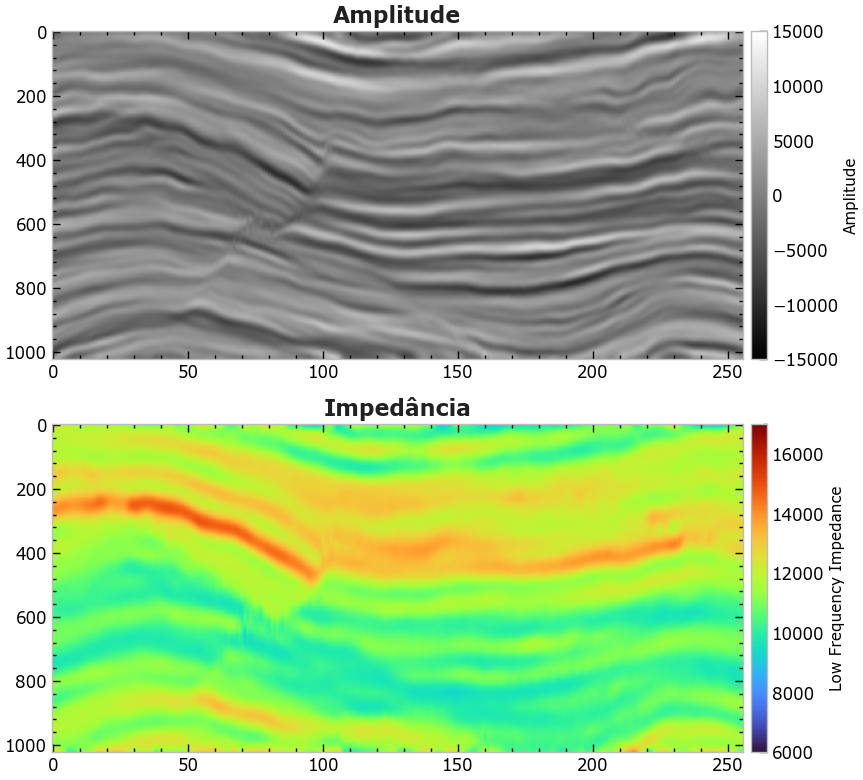

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 128

c = axs[0].imshow(
    data_amp[:, SECTION, :].T, cmap="gray", aspect="auto", vmin=-15000, vmax=15000
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("Amplitude", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title("Amplitude", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
axs[0].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[0].get_yticks()]
)  # Altera os rótulos do eixo y
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)

c = axs[1].imshow(
    imp_background[:, SECTION, :].T, cmap="turbo", aspect="auto", vmin=VMIN, vmax=VMAX
)

cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("Low Frequency Impedance", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title("Impedância", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
axs[1].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[1].get_yticks()]
)  # Altera os rótulos do eixo y
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
plt.savefig("Figures/views/amplitude_impedanceback.png", dpi=500, bbox_inches="tight")
plt.show()

## Wavelets

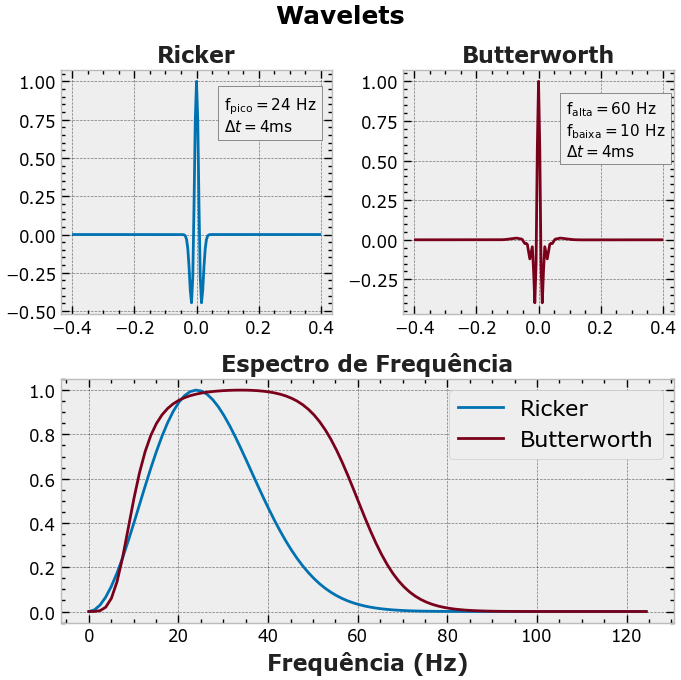

In [96]:
SAMPLE = 100
DT = 4

# Ricker
PKFQ = 24
twlet, wlet, freqs, fft = wavelets.ricker(peak_freq=PKFQ, samples=SAMPLE, dt=DT)

# Butter
FREQHI = 60
FREQLOW = 10
DTB = 4
twlet_b, wlet_b, freqs_b, fft_b = wavelets.butter(
    freq_hi=FREQHI, freq_low=FREQLOW, samples=SAMPLE, dt=DTB
)

plt.figure(figsize=(7, 7))

textstr1 = "\n".join(
    (r"$\text{f}_{\text{pico}}=%d$ Hz" % (PKFQ), r"$\Delta t=%d$ms" % (DT))
)

textstr2 = "\n".join(
    (
        r"$\text{f}_{\text{alta}}=%d$ Hz" % (FREQHI),
        r"$\text{f}_{\text{baixa}}=%d$ Hz" % (FREQLOW),
        r"$\Delta t=%d$ms" % (DTB),
    )
)

plt.suptitle("Wavelets", fontsize=18, fontweight="bold")

plt.subplot2grid((2, 2), (0, 0))
plt.plot(twlet, wlet, color=PRIMARY)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.title("Ricker", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")
plt.text(
    0.60,
    0.75,
    textstr1,
    fontsize=11,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

plt.subplot2grid((2, 2), (0, 1))
plt.plot(twlet_b, wlet_b, color=SECONDARY_DARK)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.title("Butterworth", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")
plt.text(
    0.60,
    0.65,
    textstr2,
    fontsize=11,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.plot(freqs, fft, color=PRIMARY, label="Ricker")
plt.title(
    "Espectro de Frequência", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold"
)
plt.plot(freqs_b, fft_b, color=SECONDARY_DARK, label="Butterworth")
plt.xlabel("Frequência (Hz)", color=TEXT_COLOR, fontweight="bold")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig("Figures/grid_wavelets.png", dpi=500, bbox_inches="tight")
plt.show()

In [97]:
def estimate_wavelet_deterministic(seismic_data, sampling_rate):
    nt_wav = 16
    nfft = 2**8

    fft_result = np.fft.fft(seismic_data, nfft, axis=-1)

    wav_est_fft = np.mean(np.abs(fft_result), axis=0)

    fwest = np.fft.fftfreq(nfft, d=4 / 1000)
    wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
    wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
    wav_est = wav_est / wav_est.max()
    fwest = fwest[: nfft // 2]
    wav_est_fft = wav_est_fft[: nfft // 2]

    dt = sampling_rate / 1000  # Assuming the sampling interval is 4 ms
    time_values = np.arange(-nt_wav + 1, nt_wav) * dt

    # Check the shape of wav_est
    print("Shape of wav_est:", np.shape(wav_est))

    return time_values, wav_est, fwest, wav_est_fft

tw, wav_est, fwest, west_fft = estimate_wavelet_deterministic(data_amp, 4)

Shape of wav_est: (31, 256)


## Inversão Maximum Likelihood

Utilizando mínimos quadrados

In [98]:
# parâmetros do operador
nz, nx, ny = data_amp.shape


poststack_ricker = pylops.avo.poststack.PoststackLinearModelling(
    wlet / 2, nt0=nz, spatdims=1, explicit=True
)

poststack_butter = pylops.avo.poststack.PoststackLinearModelling(
    wlet_b / 2, nt0=nz, spatdims=1, explicit=True
)

I = pylops.Identity(nz)
TIKHO = 0.5
REGS = [I]

In [99]:
import numpy as np
import pylops
from tqdm import tqdm
from joblib import Parallel, delayed


def process_trace(ix, iy, amplitude, imp_back, PPop, PPop_b, REGS, TIKHO):
    seismic_trace = amplitude[ix, iy, :].flatten()
    impedance_trace = imp_back[ix, iy, :].flatten()

    # Invert impedance using Ricker wavelet
    inverted_impedance_trace_ricker = (
        pylops.optimization.leastsquares.normal_equations_inversion(
            Op=PPop,
            y=seismic_trace,
            Regs=REGS,
            epsI=TIKHO,
            x0=impedance_trace,
            engine="scipy",
            **dict(maxiter=1000)
        )[0]
    )

    # Invert impedance using Butterworth wavelet
    inverted_impedance_section_butter = (
        pylops.optimization.leastsquares.normal_equations_inversion(
            Op=PPop_b,
            y=seismic_trace,
            Regs=REGS,
            epsI=TIKHO,
            x0=impedance_trace,
            engine="scipy",
            **dict(maxiter=1000)
        )[0]
    )

    return (ix, iy, inverted_impedance_trace_ricker, inverted_impedance_section_butter)


def max_likelihood_inverting(amplitude, imp_back, impedance, PPop, PPop_b, REGS, TIKHO):
    nx, ny, nz = amplitude.shape

    inv_imp_ricker = np.zeros_like(impedance)
    inv_imp_butter = np.zeros_like(impedance)

    # Process each trace in parallel
    results = Parallel(n_jobs=-1)(
        delayed(process_trace)(ix, iy, amplitude, imp_back, PPop, PPop_b, REGS, TIKHO)
        for ix, iy in tqdm(np.ndindex(nx, ny), desc="Processing traces")
    )

    # Collect results
    for (
        ix,
        iy,
        inverted_impedance_trace_ricker,
        inverted_impedance_section_butter,
    ) in results:
        inv_imp_ricker[ix, iy, :] = inverted_impedance_trace_ricker.reshape(nz)
        inv_imp_butter[ix, iy, :] = inverted_impedance_section_butter.reshape(nz)

    inverted_impedance_final_ricker = inv_imp_ricker + imp_back
    inverted_impedance_final_butter = inv_imp_butter + imp_back

    return inverted_impedance_final_ricker, inverted_impedance_final_butter


# Example usage
ml_inverted_impedance_final_ricker, ml_inverted_impedance_final_butter = (
    max_likelihood_inverting(
        data_amp,
        imp_background,
        data_imp,
        poststack_ricker,
        poststack_butter,
        REGS,
        TIKHO,
    )
)

Processing traces: 65536it [00:13, 4733.88it/s]


## Visualização

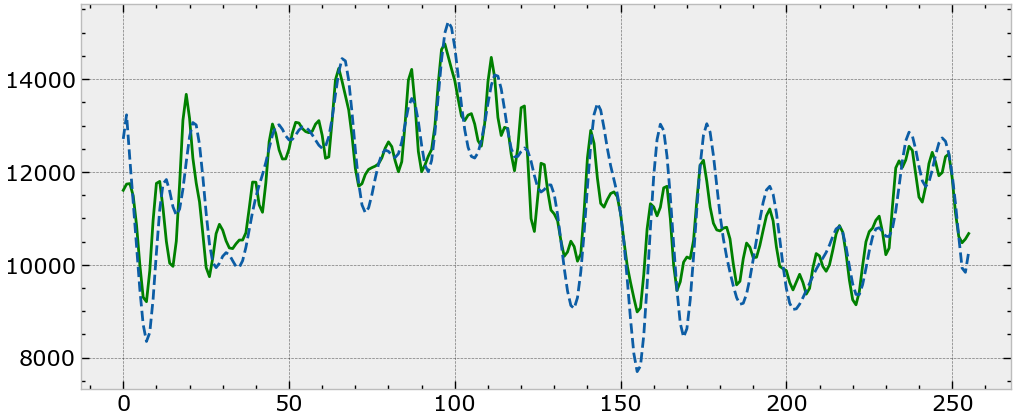

In [100]:
plt.figure(figsize=(12,5))

plt.plot(imp_30hz[128, 128, :].T, color="green")
plt.plot(ml_inverted_impedance_final_ricker[128, 128, :].T, '--')

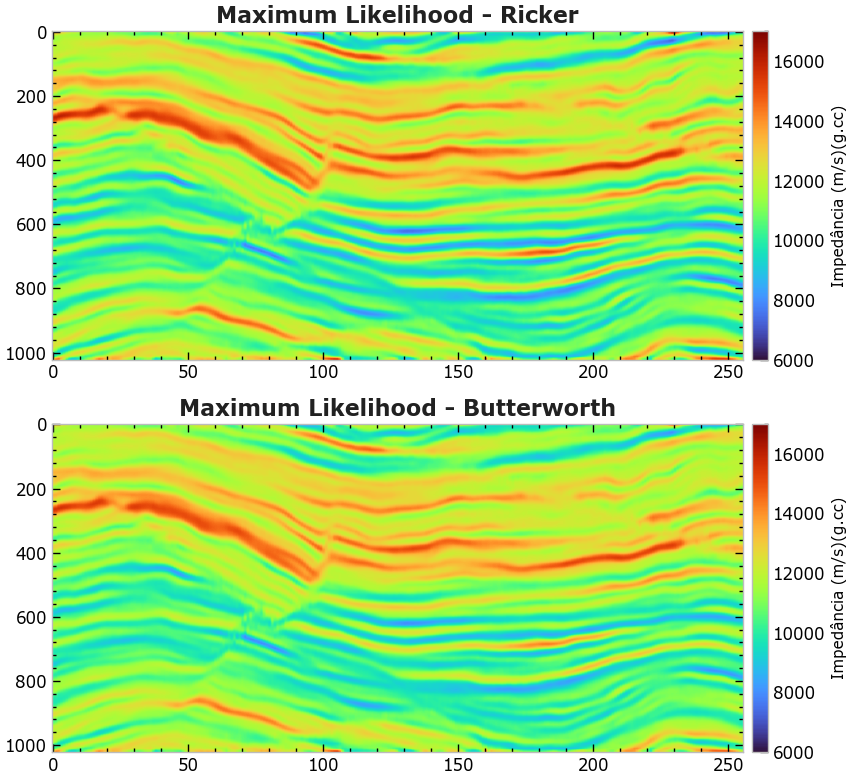

In [101]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 128

c = axs[0].imshow(
    ml_inverted_impedance_final_ricker[:, SECTION, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=VMIN,
    vmax=VMAX,
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title(
    "Maximum Likelihood - Ricker",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[0].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[0].get_yticks()]
)  # Altera os rótulos do eixo y
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)

c = axs[1].imshow(
    ml_inverted_impedance_final_butter[:, SECTION, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=VMIN,
    vmax=VMAX,
)
cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title(
    "Maximum Likelihood - Butterworth",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[1].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[1].get_yticks()]
)  # Altera os rótulos do eixo y
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
plt.savefig("Figures/views/ml_ricker_butter.png", dpi=500, bbox_inches="tight")
plt.show()

## Sparse Spike (Reis)

In [102]:
import numpy as np
import pylops
from tqdm import tqdm

# Supondo que data_amp, imp_background, wlet e wlet_b sejam arrays 3D com dimensões (ix, iy, iz)
ix, iy, iz = data_amp.shape

# Inicializar arrays para armazenar os resultados da inversão
sparse_spike_inv_ricker = np.zeros((ix, iy, iz))
sparse_spike_inv_butter = np.zeros((ix, iy, iz))
sparse_spike_inv_est = np.zeros((ix, iy, iz))
EPSI = 0.1
EPSR = 0.05
# Iterar sobre as dimensões ix e iy
for i in tqdm(range(ix), desc="Processing inversion"):
    sparse_spike_inv_ricker[i, :, :] = pylops.avo.poststack.PoststackInversion(
        data_amp[i, :, :],
        wlet / 2,
        m0=imp_background[i, :, :],
        explicit=False,
        epsI=EPSI,
        epsR=EPSR,
        #epsRL1=0.02,
        simultaneous=False,
        **dict(iter_lim=1000, damp=0.45)
    )[0]

    sparse_spike_inv_butter[i, :, :] = pylops.avo.poststack.PoststackInversion(
        data_amp[i, :, :],
        wlet_b / 2,
        m0=imp_background[i, :, :],
        explicit=False,
        epsI=EPSI,
        epsR=EPSR,
        #epsRL1=0.02,
        simultaneous=False,
        **dict(iter_lim=1000, damp=0.45)
    )[0]
    
    # sparse_spike_inv_est[i, :, :] = pylops.avo.poststack.PoststackInversion(
    #     data_amp[i, :, :],
    #     wav_est[:, i] / 2,
    #     m0=imp_background[i, :, :],
    #     explicit=False,
    #     epsI=EPSI,
    #     epsR=EPSR,
    #     #epsRL1=0.02,
    #     simultaneous=False,
    #     **dict(iter_lim=1000, damp=0.45)
    # )

# Agora sparse_spike_inv_ricker e sparse_spike_inv_butter contêm os resultados da inversão para o cubo inteiro
from scipy import stats
from scipy.stats import pearsonr as pearson

ss_correlation_ricker = pearson(
    imp_30hz.flatten(), sparse_spike_inv_ricker.flatten()
)[0]
ss_correlation_butter = pearson(
    imp_30hz.flatten(), sparse_spike_inv_butter.flatten()
)[0]

print(
    f"Pearson Global de Ricker é: {ss_correlation_ricker:.2f}"
)
print(
    f"Pearson Global de Butter é: {ss_correlation_butter:.2f}"
)

Processing inversion: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Pearson Global de Ricker é: 0.69
Pearson Global de Butter é: 0.73


In [103]:
kill = sparse_spike_inv_ricker - sparse_spike_inv_butter
print(kill[0, 0, 0])

79.32308804290187


In [91]:
kill = sparse_spike_inv_ricker - sparse_spike_inv_butter
print(kill[0, 0, 0])

75.02259229675838


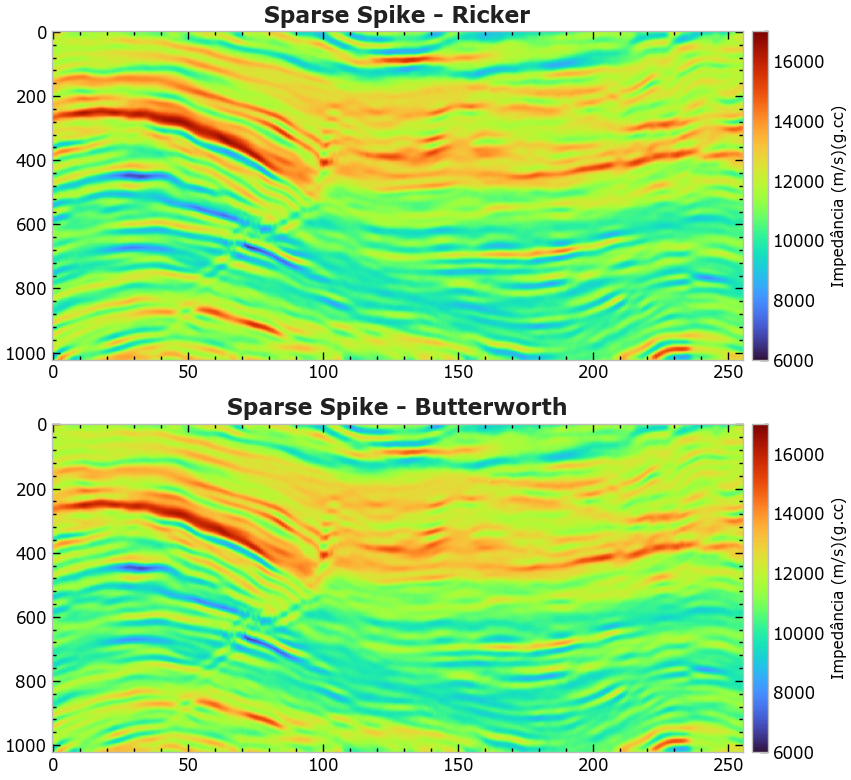

In [105]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 128

c = axs[0].imshow(
    sparse_spike_inv_ricker[:, SECTION, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=VMIN,
    vmax=VMAX,
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title(
    "Sparse Spike - Ricker", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR
)
axs[0].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[0].get_yticks()]
)  # Altera os rótulos do eixo y
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)

c = axs[1].imshow(
    sparse_spike_inv_butter[:, SECTION, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=VMIN,
    vmax=VMAX,
)
cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title(
    "Sparse Spike - Butterworth",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[1].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[1].get_yticks()]
)  # Altera os rótulos do eixo y
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
#plt.savefig("Figures/views/ss_ricker_butter.png", dpi=500, bbox_inches="tight")
plt.show()

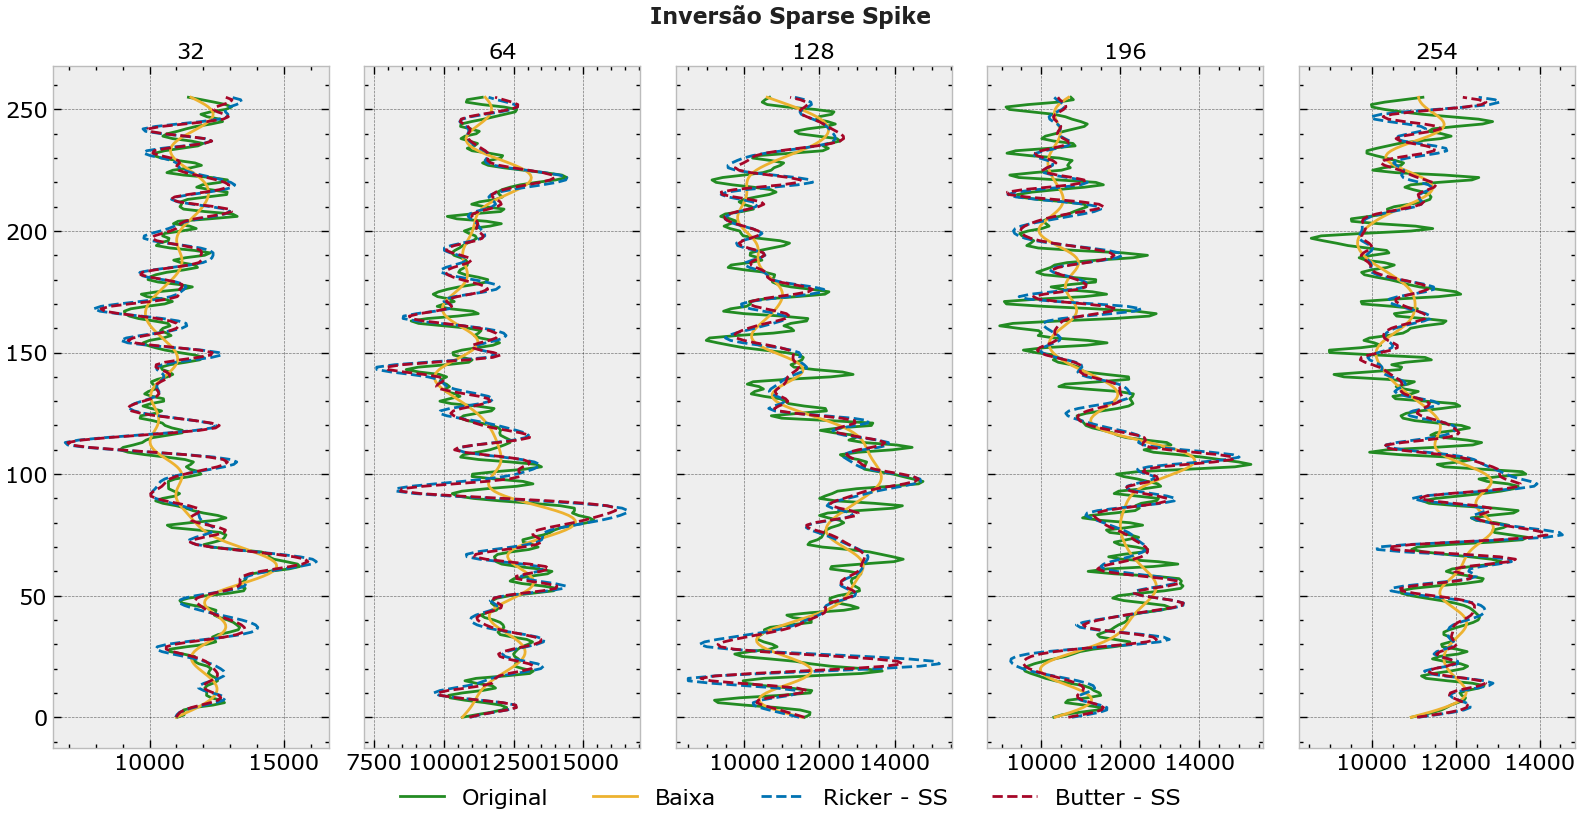

In [106]:
# 32, 64, 128, 196, 256
traco = np.arange(0, 256, 1)
SECTION = 128
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 8))

fig.suptitle("Inversão Sparse Spike", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)

indices = [32, 64, 128, 196, 254]
for i, ax in enumerate(axs):
    ax.plot(imp_30hz[indices[i], SECTION, :].T, traco,  label='Original', color=TERCIARY)
    ax.plot(imp_background[indices[i], SECTION, :].T, traco,  label='Baixa', color=ALTERNATIVE)
    ax.plot(sparse_spike_inv_ricker[indices[i], SECTION, :].T, traco,"--", label='Ricker - SS', color=PRIMARY)
    ax.plot(sparse_spike_inv_butter[indices[i], SECTION, :].T, traco,"--", label='Butter - SS', color=SECONDARY)
    #ax.grid()
    ax.set_title(f'{indices[i]}')

fig.tight_layout()

# Adiciona uma única legenda para toda a figura
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, frameon=False)

plt.show()

## Inversão Sparse Spike

Utilizando IRLS

In [ ]:
import numpy as np
from pylops.optimization.sparsity import irls
from tqdm import tqdm
from joblib import Parallel, delayed

EPSR = 0.1
EPSI = 0.05
TOLIRLS = 0.075

def process_trace(ix, iy, amplitude, imp_back, wlet, wlet_b):
    # seismic_trace = amplitude[ix, iy, :].flatten() / 10
    # impedance_trace = imp_back[ix, iy, :].flatten()

    sparse_spike_inv_ricker[i, :, :] = pylops.avo.poststack.PoststackInversion(
        amplitude[i, :, :]/10,
        wlet / 2,
        m0=imp_back[i, :, :],
        explicit=False,
        epsI=0.2,
        epsR=0.02,
        #epsRL1=0.02,
        simultaneous=False,
        **dict(iter_lim=100, damp=0.2)
    )[0]

    sparse_spike_inv_butter[i, :, :] = pylops.avo.poststack.PoststackInversion(
        data_amp[i, :, :]/10,
        wlet_b / 2,
        m0=imp_background[i, :, :],
        explicit=False,
        epsI=0.2,
        epsR=0.02,
        #epsRL1=0.02,
        simultaneous=False,
        **dict(iter_lim=100, damp=0.2)
    )[0]
    
    return (ix, iy, sparse_spike_inv_ricker, sparse_spike_inv_butter)


def sparse_spike_inverting(amplitude, imp_back, impedance, wlet, wlet_b):
    nx, ny, nz = amplitude.shape

    inv_imp_ricker = np.zeros_like(impedance)
    inv_imp_butter = np.zeros_like(impedance)

    results = Parallel(n_jobs=-1)(
        delayed(process_trace)(ix, iy, amplitude, imp_back, wlet, wlet_b)
        for ix, iy in tqdm(np.ndindex(nx, ny), desc="Processing traces")
    )

    for (
        ix,
        iy,
        inverted_impedance_trace_ricker,
        inverted_impedance_section_butter,
    ) in results:
        inv_imp_ricker[ix, iy, :] = inverted_impedance_trace_ricker#.reshape(nz)
        inv_imp_butter[ix, iy, :] = inverted_impedance_section_butter#.reshape(nz)

    inverted_impedance_final_ricker = inv_imp_ricker #+ imp_back
    inverted_impedance_final_butter = inv_imp_butter #+ imp_back

    return inverted_impedance_final_ricker, inverted_impedance_final_butter


# Example usage
ss_inverted_impedance_final_ricker, ss_inverted_impedance_final_butter = (
    sparse_spike_inverting(
        data_amp, imp_background, data_imp, wlet, wlet_b
    )
)
np.max(ss_inverted_impedance_final_ricker)

Processing traces: 24it [00:00, 154.27it/s]

ValueError: assignment destination is read-only

Processing traces: 24it [00:11, 154.27it/s]

##### Ricker e Butterworth

In [ ]:
import numpy as np
from pylops.optimization.sparsity import irls
from tqdm import tqdm
from joblib import Parallel, delayed

EPSR = 0.1
EPSI = 0.05
TOLIRLS = 0.075

def process_trace(ix, iy, amplitude, imp_back, PPop, PPop_b, TIKHO):
    seismic_trace = amplitude[ix, iy, :].flatten() / 10
    impedance_trace = imp_back[ix, iy, :].flatten()

    inverted_impedance_trace_ricker = irls(
        Op=PPop,
        y=seismic_trace,
        #threshR=True,
        #epsR=EPSR,
        epsI=EPSI,
        x0=impedance_trace,
        nouter=4,
        tolIRLS=TOLIRLS,
        kind='model',
        **dict(iter_lim=1000)
    )[0]

    inverted_impedance_section_butter = irls(
        Op=PPop_b,
        y=seismic_trace,
        #threshR=True,
        #epsR=EPSR,
        epsI=EPSI, # 0.5 e 0.05
        x0=impedance_trace,
        nouter=4,
        tolIRLS=TOLIRLS,
        kind='model',
        **dict(iter_lim=1000)
    )[0]

    return (ix, iy, inverted_impedance_trace_ricker, inverted_impedance_section_butter)


def sparse_spike_inverting(amplitude, imp_back, impedance, PPop, PPop_b, TIKHO):
    nx, ny, nz = amplitude.shape

    inv_imp_ricker = np.zeros_like(impedance)
    inv_imp_butter = np.zeros_like(impedance)

    results = Parallel(n_jobs=-1)(
        delayed(process_trace)(ix, iy, amplitude, imp_back, PPop, PPop_b, TIKHO)
        for ix, iy in tqdm(np.ndindex(nx, ny), desc="Processing traces")
    )

    for (
        ix,
        iy,
        inverted_impedance_trace_ricker,
        inverted_impedance_section_butter,
    ) in results:
        inv_imp_ricker[ix, iy, :] = inverted_impedance_trace_ricker.reshape(nz)
        inv_imp_butter[ix, iy, :] = inverted_impedance_section_butter.reshape(nz)

    inverted_impedance_final_ricker = inv_imp_ricker #+ imp_back
    inverted_impedance_final_butter = inv_imp_butter #+ imp_back

    return inverted_impedance_final_ricker, inverted_impedance_final_butter


# Example usage
ss_inverted_impedance_final_ricker, ss_inverted_impedance_final_butter = (
    sparse_spike_inverting(
        data_amp, imp_background, data_imp, poststack_ricker, poststack_butter, TIKHO
    )
)
np.max(ss_inverted_impedance_final_ricker)

Processing traces: 65536it [38:53, 28.08it/s]


np.float64(19702.2561534095)

# Visualização

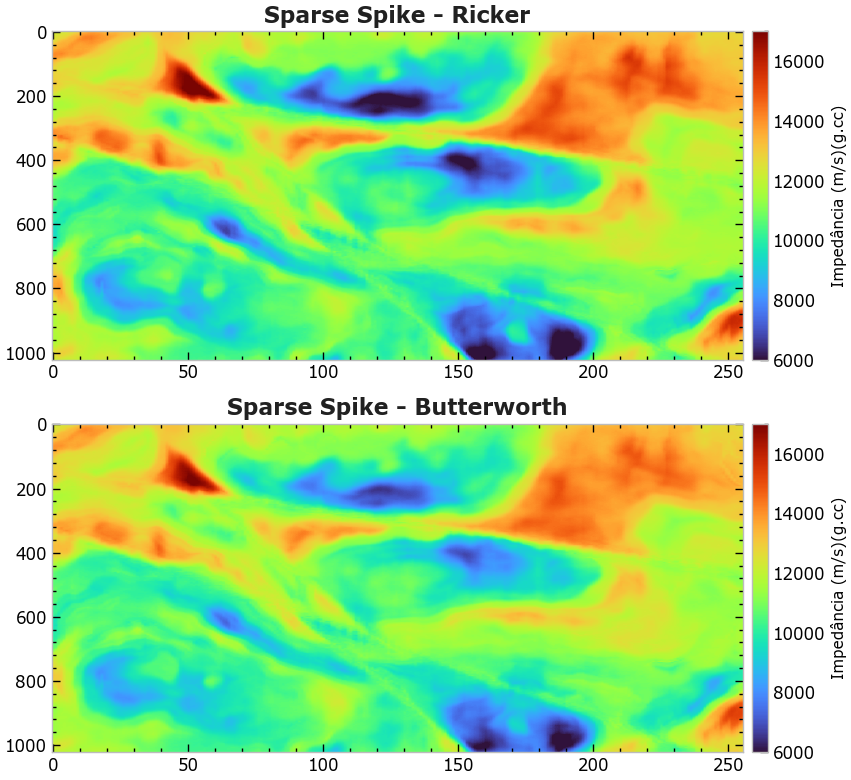

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 128

c = axs[0].imshow(
    ss_inverted_impedance_final_ricker[:, SECTION, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=VMIN,
    vmax=VMAX,
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title(
    "Sparse Spike - Ricker", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR
)
axs[0].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[0].get_yticks()]
)  # Altera os rótulos do eixo y
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)

c = axs[1].imshow(
    ss_inverted_impedance_final_butter[:, SECTION, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=VMIN,
    vmax=VMAX,
)
cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title(
    "Sparse Spike - Butterworth",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[1].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[1].get_yticks()]
)  # Altera os rótulos do eixo y
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
#plt.savefig("Figures/views/ss_ricker_butter.png", dpi=500, bbox_inches="tight")
plt.show()

In [19]:
dif = ss_inverted_impedance_final_ricker - ss_inverted_impedance_final_butter

# Exportando

In [94]:
ricker_max_likelihood = ml_inverted_impedance_final_ricker
butter_max_likelihood = ml_inverted_impedance_final_butter
# ricker_sparse_spike = ss_inverted_impedance_final_ricker
ricker_sparse_spike = sparse_spike_inv_ricker
# butter_sparse_spike = ss_inverted_impedance_final_butter
butter_sparse_spike = sparse_spike_inv_butter

In [95]:
# np.save("Uncompressed/impedance_30hz.npy", imp_30hz)
# np.save("Uncompressed/impedance_background.npy", imp_background)
# np.save("Uncompressed/max_likelihood_ricker.npy",ricker_max_likelihood)
# np.save("Uncompressed/max_likelihood_butter.npy",butter_max_likelihood)
# np.save("Uncompressed/sparse_spike_ricker.npy", ricker_sparse_spike)
# np.save("Uncompressed/sparse_spike_butter.npy", butter_sparse_spike)

import polars as pl

# Create a Polars DataFrame
df = pl.DataFrame({
    'imp_org': imp_30hz.flatten(),
    'imp_back': imp_background.flatten(),
    'ricker_ML': ricker_max_likelihood.flatten(),
    'butter_ML': butter_max_likelihood.flatten(),
    'ricker_SS': ricker_sparse_spike.flatten(),
    'butter_SS': butter_sparse_spike.flatten()
})

# Exibir as primeiras linhas do DataFrame
# print(df.head())
print(df)
df_numpy = df.to_numpy()
np.save('Uncompressed/inversion_data.npy', df_numpy)

shape: (16_777_216, 6)
┌──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ imp_org      ┆ imp_back     ┆ ricker_ML    ┆ butter_ML    ┆ ricker_SS    ┆ butter_SS    │
│ ---          ┆ ---          ┆ ---          ┆ ---          ┆ ---          ┆ ---          │
│ f64          ┆ f64          ┆ f64          ┆ f64          ┆ f64          ┆ f64          │
╞══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 10819.119441 ┆ 10852.387291 ┆ 11177.353693 ┆ 11191.161548 ┆ 11623.877822 ┆ 11548.85523  │
│ 10885.680272 ┆ 10673.823274 ┆ 11095.643836 ┆ 11120.400523 ┆ 11673.211895 ┆ 11566.815214 │
│ 10640.230935 ┆ 10497.877413 ┆ 10587.153681 ┆ 10611.615772 ┆ 11661.326774 ┆ 11529.163131 │
│ 10136.763343 ┆ 10330.940254 ┆ 10264.027366 ┆ 10299.850456 ┆ 11540.785365 ┆ 11401.953897 │
│ 9731.175234  ┆ 10179.073569 ┆ 10021.693447 ┆ 10069.010314 ┆ 11285.679015 ┆ 11169.554654 │
│ …            ┆ …            ┆ …            ┆ …         

In [76]:
pip install polars

   ---------------------------------------- 0.0/35.1 MB ? eta -:--:--
   -- ------------------------------------- 2.4/35.1 MB 11.4 MB/s eta 0:00:03
   ----- ---------------------------------- 4.7/35.1 MB 11.6 MB/s eta 0:00:03
   -------- ------------------------------- 7.1/35.1 MB 11.7 MB/s eta 0:00:03
   ----------- ---------------------------- 9.7/35.1 MB 11.7 MB/s eta 0:00:03
   ------------- -------------------------- 12.1/35.1 MB 11.8 MB/s eta 0:00:02
   ---------------- ----------------------- 14.4/35.1 MB 11.7 MB/s eta 0:00:02
   ------------------- -------------------- 17.0/35.1 MB 11.8 MB/s eta 0:00:02
   ---------------------- ----------------- 19.7/35.1 MB 11.8 MB/s eta 0:00:02
   ------------------------- -------------- 22.0/35.1 MB 11.8 MB/s eta 0:00:02
   ---------------------------- ----------- 24.6/35.1 MB 11.8 MB/s eta 0:00:01
   ------------------------------ --------- 27.0/35.1 MB 11.8 MB/s eta 0:00:01
   --------------------------------- ------ 29.4/35.1 MB 11.8 MB/


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
